# Transformer based model to translate English text to Python code
# Experiment 4 - Model with data augmentation and glove embedding

The goal is to  write a transformer-based model that can translats English text to python code(with proper whitespace indentations)

The training dataset contains around 4600+ examples of English text to python code. 
- must use transformers with self-attention, multi-head, and scaled-dot product attention in the model
- There is no limit on the number of training epochs or total number of parameters in the model
- should have trained a separate embedding layer for python keywords and paid special attention to whitespaces, colon and other things (like comma etc)
- model should to do proper indentation
- model should to use newline properly
- model should understand how to use colon (:)
- model should generate proper python code that can run on a Python interpreter and produce proper results


Some preprocessing checks on the dataset should be carried out like:
 - the dataset provided is divided into English and "python-code" pairs properly
the dataset does not have anomalies w.r.t. indentations (like a mixed-use of tabs and spaces, or use of either 4 or 3 spaces, it should be 4 spaces only). Either use tabs only or 4 spaces only, not both
- the length of the "python-code" generated is not out of your model's capacity


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torchtext
from torchtext.legacy import data 
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchtext.vocab as vocab
import unicodedata
import codecs
import csv
import time
import random
import re
import os
import pickle
from io import open
import itertools
import math
import pandas as pd
from torchtext.legacy.data import Field, BucketIterator, LabelField, TabularDataset

BASE_DIR='/content/drive/MyDrive/seq2py'
#https://stackoverflow.com/questions/62922640/calling-a-function-in-a-different-python-file-using-google-colab
%cd $BASE_DIR/utils
import preprocess, helper

/content/drive/MyDrive/seq2py/utils


In [3]:
#Then set a random seed for deterministic results/reproducability.
SEED = 2345
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

#Data Processing

The first step towards any machine learning is input data processing, the input in our case is going to be the English text and output would be a python source code. However, computers don't understand text the only language they understand is of matrices and numbers, we will therefore have to transform the input text into numbers.

So to do that, first we take all the words present in the training data and create a vocabulary out of it. If our training data is as big as a wikipedia, our vocabulary can be composed of all the words in english language. Next, we assign a numeric index next to each word and then we pick only the words that occur in the current input text. Therefore, what gets fed into the transformer are not the english words or python syntax but their corresponding indices.

In next few blocks lets first, preprocess and prepare the data before we feed it to the transformer model.

In [4]:
datasets = preprocess.read_data(file_name=os.path.join(BASE_DIR,'data/english_python_data_processed.txt'))
df_original = preprocess.tranform_to_dataframe(datasets)
df_original.head()

,Description,Code
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...
2,write a python program to subtract two numbers,\nnum1 = 6\nnum2 = 3\ndiff = num1 - num2\nprin...
3,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n sum = nu..."
4,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
5,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...


Split the data into train and test set, so that data augmentation is applied only on the training set

In [5]:
train_df=df_original.sample(frac=0.8,random_state=SEED) #random state is a seed value
test_df=df_original.drop(train_df.index)

In [6]:
len(train_df), len(test_df)

(3512, 878)

## Data Augmentation on training set

Replace all the occurance with "write a" in the english text description

In [7]:
df_temp=train_df[train_df.Description.str.contains('write a')]
df_temp['Description'] = df_temp.Description.replace({"write a": " "},regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Delete Random words
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [8]:
def random_deletion(words, p=0.2): 
    # if len(words) == 1: # return if single word
    #     return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

In [9]:
random_deletion_df = df_temp[df_temp['Description'].str.count('\s+')>10].sample(frac=0.5)
random_deletion_df['Description'] = random_deletion_df.Description.str.split().apply(random_deletion).apply(' '.join)
random_deletion_df.head(5)

,Description,Code
1481,python program to dictionary by its values and...,"\nd = {'apple': 10, 'orange': 20, 'banana': 5,..."
169,function that would the given input path and p...,def read_and_print_file(filepath):\n with o...
1936,Python program that dictionary keys to list us...,"test_dict = {'Geeks' : 2, 'for' : 1, 'CS' : 3}..."
3575,that creates a dictionary whose keys numbers f...,"square_dict = {}\nfor i in range(1, 11):\n ..."
176,recursive python that takes a list or tuple an...,def reverse(seq):\n SeqType = type(seq)\n ...


## Random swap 
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [10]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [11]:
random_swap_df = train_df[train_df['Description'].str.count('\s+')>10].sample(frac=0.5)
random_swap_df['Description'] = random_swap_df.Description.str.split().apply(random_swap).apply(' '.join)
random_swap_df

,Description,Code
3357,value a program print to python a character wr...,str1 = 'a'\nprint(ord(str1))\n\n
695,Create using function of list not lambda but n...,my_list = [lambda: i for i in range(5)]\nfor l...
4107,"63 Write a returns function which negative, tr...",\ndef are_all_negative(arr):\n filt_arr = l...
3602,list a python function strings joins that in r...,"def join_string_parts(str_list):\n return ""..."
4236,write Python3 of to + conversion of list code ...,"\ntest_list = [('G', 'E', 'E', 'K', 'S'), ('F'..."
...,...,...
3685,number a natural missing to find of function n...,def getMissingNo(A): \n n = len(A) \n to...
843,write a cosmos. a generate Unique function and...,def get_uuid():\n import uuid\n return u...
4019,a a dictionary get all values from and diction...,"speed ={'jan':47, 'feb':52, 'march':47, 'Apri..."
76,the minimum value program to Get write maximum...,"\nmy_dict = {'x':500, 'y':5874, 'z': 560}\nkey..."


# Create final dataset

In [12]:
final_train_df = pd.concat([train_df,random_deletion_df,random_swap_df,df_temp], axis=0).reset_index(drop=True)
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  6468 non-null   object
 1   Code         6468 non-null   object
dtypes: object(2)
memory usage: 101.2+ KB


TorchText's Fields handle how data should be processed.

We set the tokenize argument to the correct tokenization function for each, with English being the SRC (source) field and python code being the TRG (target) field. The field also appends the "start of sequence" and "end of sequence" tokens via the init_token and eos_token arguments, and converts all words to lowercase (only for src), batch_first is set to True so that TorchText can return the tensors of dimension [batch size, sequence length].

In [13]:
SRC = Field(tokenize= preprocess.tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

TRG = Field(tokenize = preprocess.tokenize_python_code, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=False,
            batch_first=True)

# Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:
fields = [('Description', SRC),('Code',TRG)]

Armed with our declared fields, lets convert from pandas to list to torchtext.

In [14]:
train_example = [data.Example.fromlist([final_train_df.Description.iloc[i],final_train_df.Code.iloc[i]], fields) for i in range(final_train_df.shape[0])] 
test_example = [data.Example.fromlist([test_df.Description.iloc[i],test_df.Code.iloc[i]], fields) for i in range(test_df.shape[0])] 

# Creating dataset
train_data = data.Dataset(train_example, fields)
test = data.Dataset(test_example, fields)

(valid_data,test_data) = test.split(split_ratio=[0.80,0.20], random_state=random.seed(SEED))


In [15]:
len(train_data), len(valid_data), len(test_data)

(6468, 702, 176)

In [16]:
print(vars(train_data.examples[0]))


{'Description': ['write', 'a', 'function', 'that', 'takes', 'number', 'of', 'disks', 'in', 'tower', 'of', 'hanaoi', 'problem', 'and', 'returns', 'the', 'minimum', 'number', 'of', 'steps', 'required'], 'Code': ['', '\n', '', 'def', 'hanoi', '(', 'x', ')', ':', '\n', '\t', 'if', 'x', '==', '1', ':', '\n', '\t\t', 'return', '1', '\n', '\t', 'else', ':', '\n', '\t\t', 'return', '2', '*', 'hanoi', '(', 'x', '-', '1', ')', '+', '1', '']}


#Load custom embedding

We can only load our custom embeddings after they have been turned into a Vectors object.

We create a Vector object by passing it the location of the embeddings (name) and a function that will later initialize tokens in our embeddings that aren't within our dataset (unk_init). 

Refer this [notebook](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/C%20-%20Loading%2C%20Saving%20and%20Freezing%20Embeddings.ipynb) for how to load custom word embeddings in TorchText, how to save all the embeddings we learn during training and how to freeze/unfreeze embeddings during training.

In [17]:
!pwd

/content/drive/MyDrive/seq2py/utils


In [18]:
custom_embeddings = vocab.Vectors(name = os.path.join(BASE_DIR,'model/emb_word2vec_format.txt'),
                                  unk_init = torch.Tensor.normal_)

In [19]:
SRC.build_vocab(train_data)
TRG.build_vocab(train_data,vectors=custom_embeddings)

In [20]:
#save the dictionary as pickle file to be used during inference
with open(os.path.join(BASE_DIR ,"model/src_stio.pkl"),"wb") as f:
  pickle.dump(SRC.vocab.stoi,f)
with open(os.path.join(BASE_DIR ,"model/src_itos.pkl"),"wb") as f:
  pickle.dump(SRC.vocab.itos,f)


#save the dictionary as pickle file to be used during inference
with open(os.path.join(BASE_DIR ,"model/trg_stio.pkl"),"wb") as f:
  pickle.dump(TRG.vocab.stoi,f)
with open(os.path.join(BASE_DIR ,"model/trg_itos.pkl"),"wb") as f:
  pickle.dump(TRG.vocab.itos,f)

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a src attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a trg attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

When we get a batch of examples using an iterator, we use a BucketIterator instead of the standard Iterator as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences.

In [21]:
BATCH_SIZE=16
train_iterator, valid_iterator,test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Code),
    device = device)

#Seq2Seq

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]


        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]        
        return output, attention

# Encoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
 
            
        return src

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

# Multi-head Attention Layer

In [25]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

# Position-wise Feedforward Layer

Another key component in the Transformer block is called position-wise feed-forward network (FFN) this is relatively simple compared to the multi-head attention layer. It accepts a 3-dimensional input with shape [batch size, sequence length, hid dimension].

The position-wise FFN consists of two dense layers. Since the same two dense layers are used for each position item in the sequence, we referred to it as position-wise. It is equivalent to applying two 1×1 convolution layers.

The input is transformed from hid_dim to pf_dim, where pf_dim is usually a lot larger than hid_dim. The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

In [26]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

#Decoder

In [27]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

# Training the Seq2Seq Model
Now we have our model implemented, we can begin training it.

First, we'll initialize our model, we define all of the hyperparameters, initialize the encoder and decoder, and initialize the overall model - placing it on the GPU if we have one.

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM=256
ENC_LAYERS = 3
DEC_LAYERS = 4
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.15
DEC_DROPOUT = 0.15

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)


dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT,
              device)


In [30]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]


model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

# we initialize our embedding layer to use our vocabulary vectors.
embeddings = TRG.vocab.vectors
model.decoder.tok_embedding.weight.data.copy_(embeddings)

#  we initialize the unknown and padding token embeddings to all zeros.
model.decoder.tok_embedding.weight.data[TRG_UNK_IDX] = torch.zeros(HID_DIM)
model.decoder.tok_embedding.weight.data[TRG_PAD_IDX] = torch.zeros(HID_DIM)

In [31]:
print(f'The model has {helper.count_parameters(model):,} trainable parameters')

The model has 8,883,570 trainable parameters


In [32]:
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(2141, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
        )
  


# Freezing and Unfreezing Embeddings
We're going to train our model for 20 epochs. During the first 10 epochs we are going to freeze the weights (parameters) of our embedding layer. For the last 10 epochs we'll allow our embeddings to be trained.

Why would we ever want to do this? Sometimes the pre-trained word embeddings we use will already be good enough and won't need to be fine-tuned with our model. If we keep the embeddings frozen then we don't have to calculate the gradients and update the weights for these parameters, giving us faster training times. This doesn't really apply for the model used here, but we're mainly covering it to show how it's done. Another reason is that if our model has a large amount of parameters it may make training difficult, so by freezing our pre-trained embeddings we reduce the amount of parameters needing to be learned.

To freeze the embedding weights, we set model.embedding.weight.requires_grad to False. This will cause no gradients to be calculated for the weights in the embedding layer, and thus no parameters will be updated when optimizer.step() is called.

Then, during training we check if FREEZE_FOR (which we set to 10) epochs have passed. If they have then we set model.embedding.weight.requires_grad to True, telling PyTorch that we should calculate gradients in the embedding layer and update them with our optimizer. [Refer](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/C%20-%20Loading%2C%20Saving%20and%20Freezing%20Embeddings.ipynb)

In [33]:
LEARNING_RATE = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
model.apply(helper.initialize_weights);
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
N_EPOCHS = 20
CLIP = 1
FREEZE_FOR = 10

#freeze embeddings
model.decoder.tok_embedding.weight.requires_grad = unfrozen = False

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = helper.train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = helper.evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = helper.epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(BASE_DIR,"model/tut6-model_20210311_run4_glove_augmentation.pt"))
    if (epoch + 1) >= FREEZE_FOR:
      #unfreeze embeddings
      model.decoder.tok_embedding.weight.requires_grad = unfrozen = True
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 26s
	Train Loss: 3.672 | Train PPL:  39.313
	 Val. Loss: 2.625 |  Val. PPL:  13.799
Epoch: 02 | Time: 0m 27s
	Train Loss: 2.449 | Train PPL:  11.581
	 Val. Loss: 2.229 |  Val. PPL:   9.291
Epoch: 03 | Time: 0m 27s
	Train Loss: 2.083 | Train PPL:   8.032
	 Val. Loss: 2.007 |  Val. PPL:   7.439
Epoch: 04 | Time: 0m 27s
	Train Loss: 1.825 | Train PPL:   6.205
	 Val. Loss: 1.851 |  Val. PPL:   6.367
Epoch: 05 | Time: 0m 26s
	Train Loss: 1.616 | Train PPL:   5.031
	 Val. Loss: 1.738 |  Val. PPL:   5.685
Epoch: 06 | Time: 0m 27s
	Train Loss: 1.439 | Train PPL:   4.218
	 Val. Loss: 1.658 |  Val. PPL:   5.247
Epoch: 07 | Time: 0m 26s
	Train Loss: 1.289 | Train PPL:   3.628
	 Val. Loss: 1.564 |  Val. PPL:   4.778
Epoch: 08 | Time: 0m 27s
	Train Loss: 1.165 | Train PPL:   3.207
	 Val. Loss: 1.515 |  Val. PPL:   4.550
Epoch: 09 | Time: 0m 26s
	Train Loss: 1.060 | Train PPL:   2.886
	 Val. Loss: 1.464 |  Val. PPL:   4.324
Epoch: 10 | Time: 0m 26s
	Train Loss: 0.967 | Train PPL

In [34]:

model.load_state_dict(torch.load(os.path.join(BASE_DIR,"model/tut6-model_20210311_run4_glove_augmentation.pt")))

test_loss = helper.evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.390 | Test PPL:   4.016 |


In [35]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(25,40))
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [36]:
example_idx = 2

src = vars(train_data.examples[example_idx])['Description']
trg = vars(train_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')
print(" ".join(trg).replace(' . ','.'))

src = ['write', 'a', 'function', 'to', 'return', 'the', 'total', 'surface', 'area', 'of', 'a', 'cuboid', 'of', 'length', 'l', ',', 'bredth', 'b', 'and', 'height', 'h']
trg = ['', 'def', 'cal_surface_area_cuboid', '(', 'l', ',', 'b', ',', 'h', ')', ':', '\n', '\t', 'return', '2', '*', '(', 'l', '*', 'b', '+', 'b', '*', 'h', '+', 'h', '*', 'l', ')', '']
 def cal_surface_area_cuboid ( l , b , h ) : 
 	 return 2 * ( l * b + b * h + h * l ) 


In [37]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

print(" ".join(translation))

predicted trg = ['', 'def', 'cal_surface_area_cuboid', '(', 'l', ',', 'b', ',', 'h', ')', ':', '\n', '\t', 'return', '2', '*', 'b', '*', 'l', '*', 'l', '', '<eos>']
 def cal_surface_area_cuboid ( l , b , h ) : 
 	 return 2 * b * l * l  <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


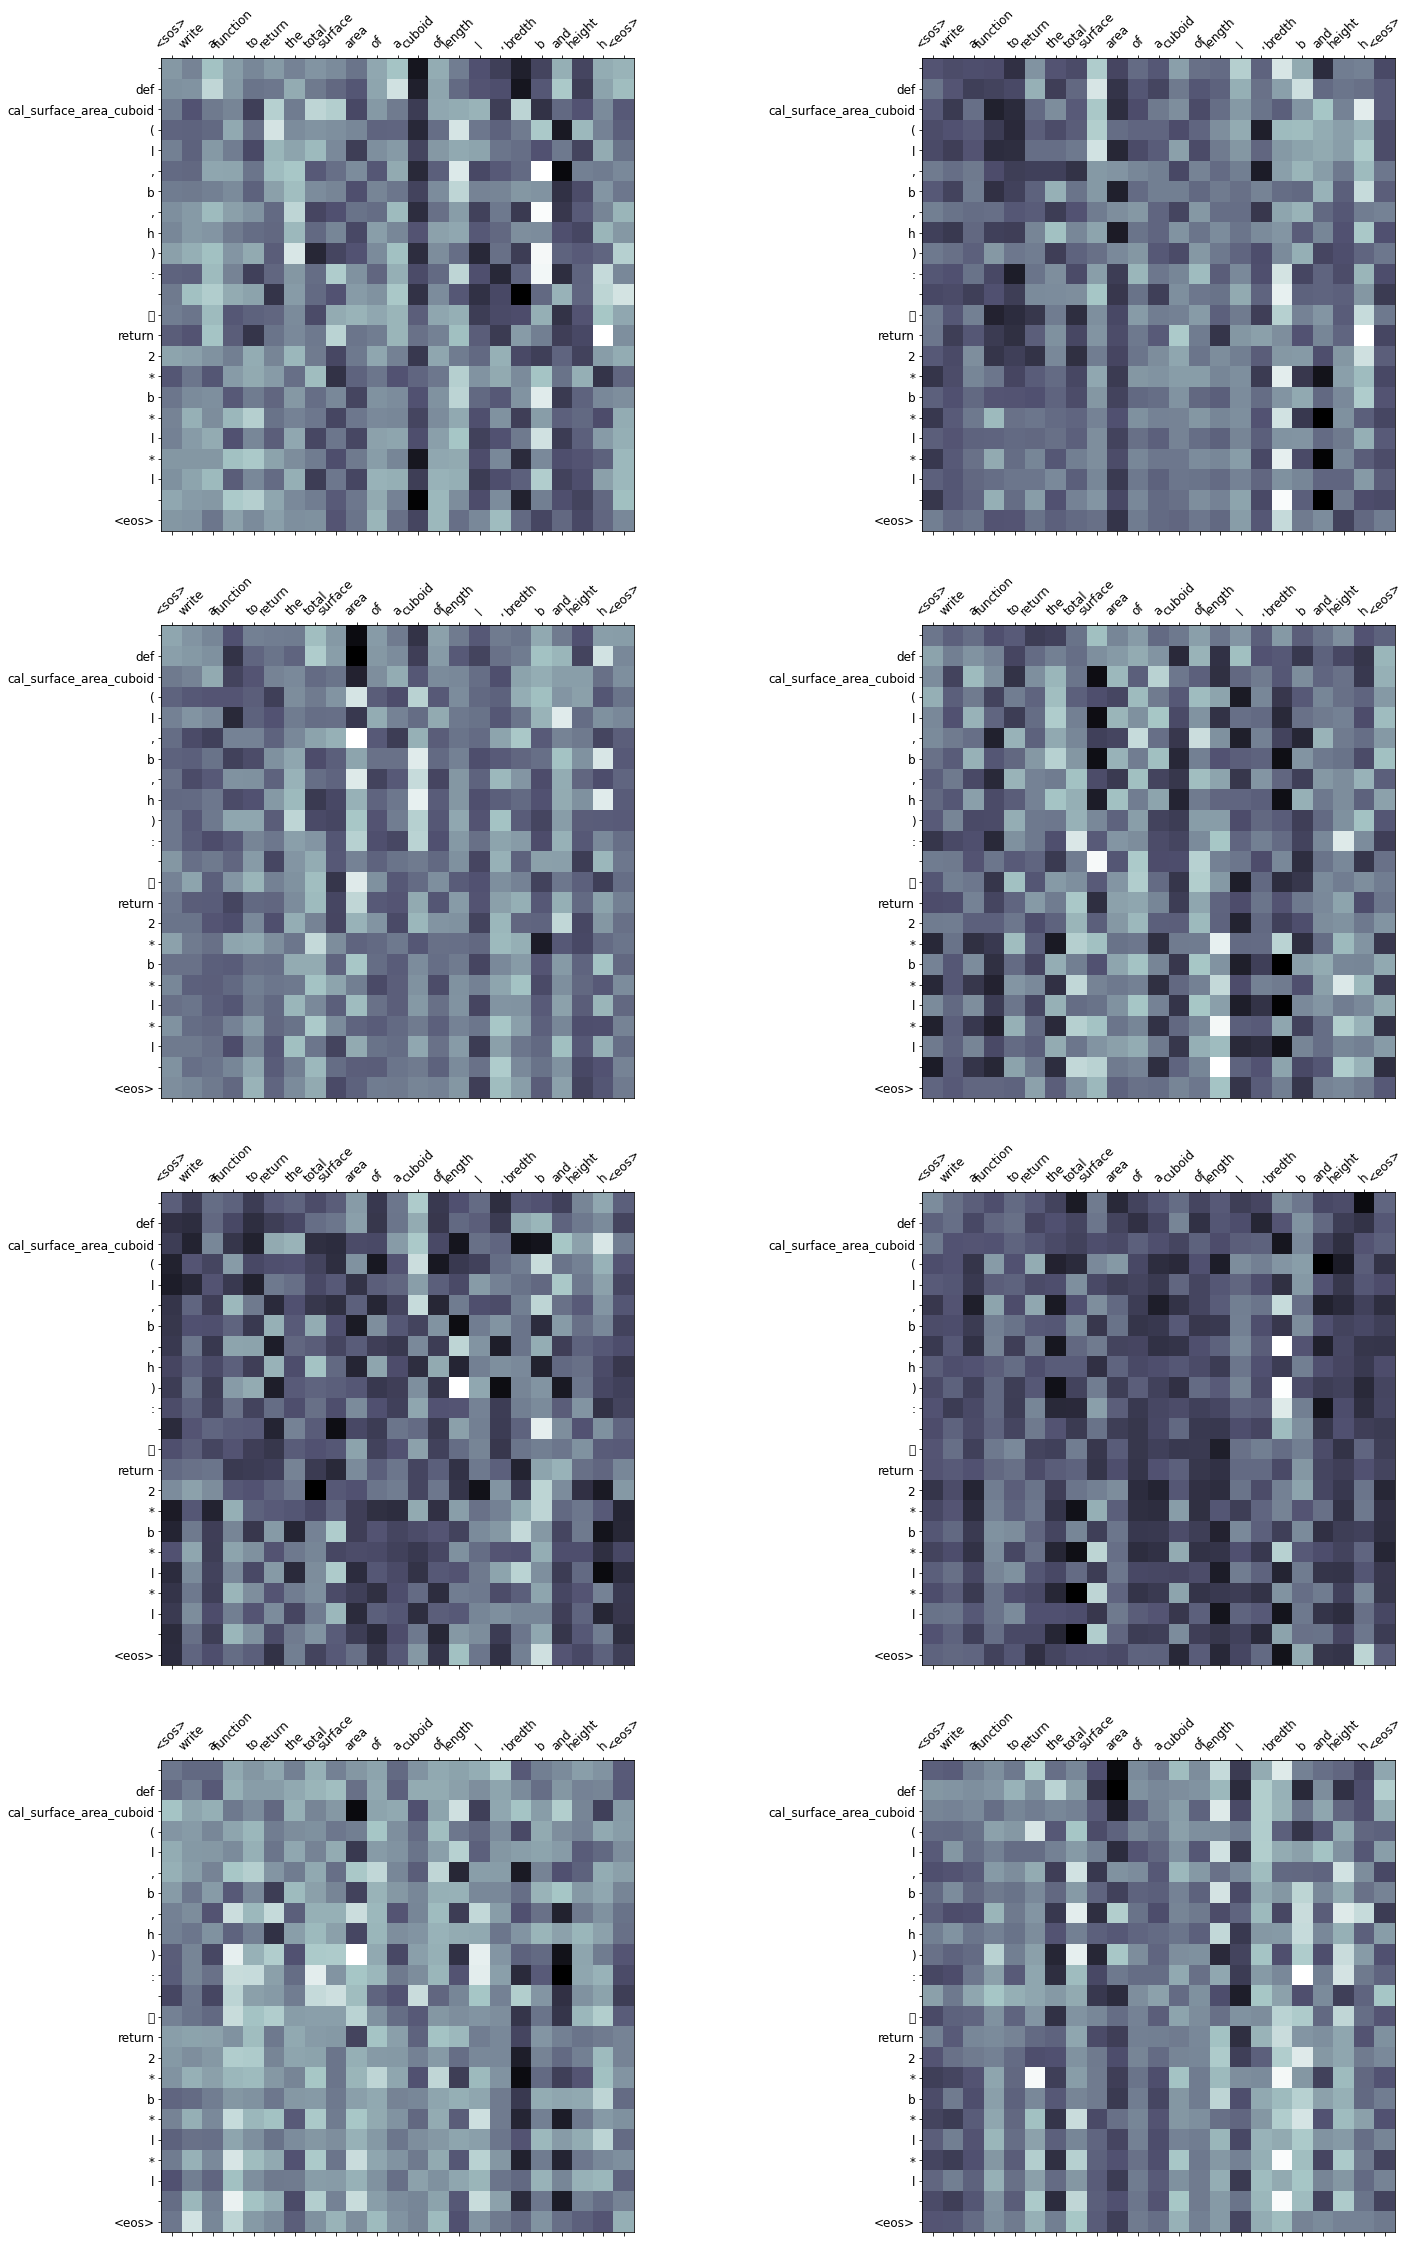

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rc('axes', unicode_minus=False)
display_attention(src, translation, attention)

In [39]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['Description']
trg = vars(valid_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')

print(" ".join(trg))

src = ['write', 'a', 'python', 'function', 'to', 'add', 'two', 'user', 'provided', 'numbers', 'and', 'return', 'the', 'sum']
trg = ['', 'def', 'add_two_numbers', '(', 'num1', ',', 'num2', ')', ':', '\n', '\t', 'sum', '=', 'num1', '+', 'num2', '\n', '\t', 'return', 'sum', '']
 def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 	 return sum 


In [40]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
print(" ".join(translation))

predicted trg = ['', 'def', 'add_two_numbers', '(', 'num1', ',', 'num2', ')', ':', '\n', '\t', 'sum', '=', 'num1', '+', 'num2', '\n', '\t', 'return', 'sum', '', '<eos>']
 def add_two_numbers ( num1 , num2 ) : 
 	 sum = num1 + num2 
 	 return sum  <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


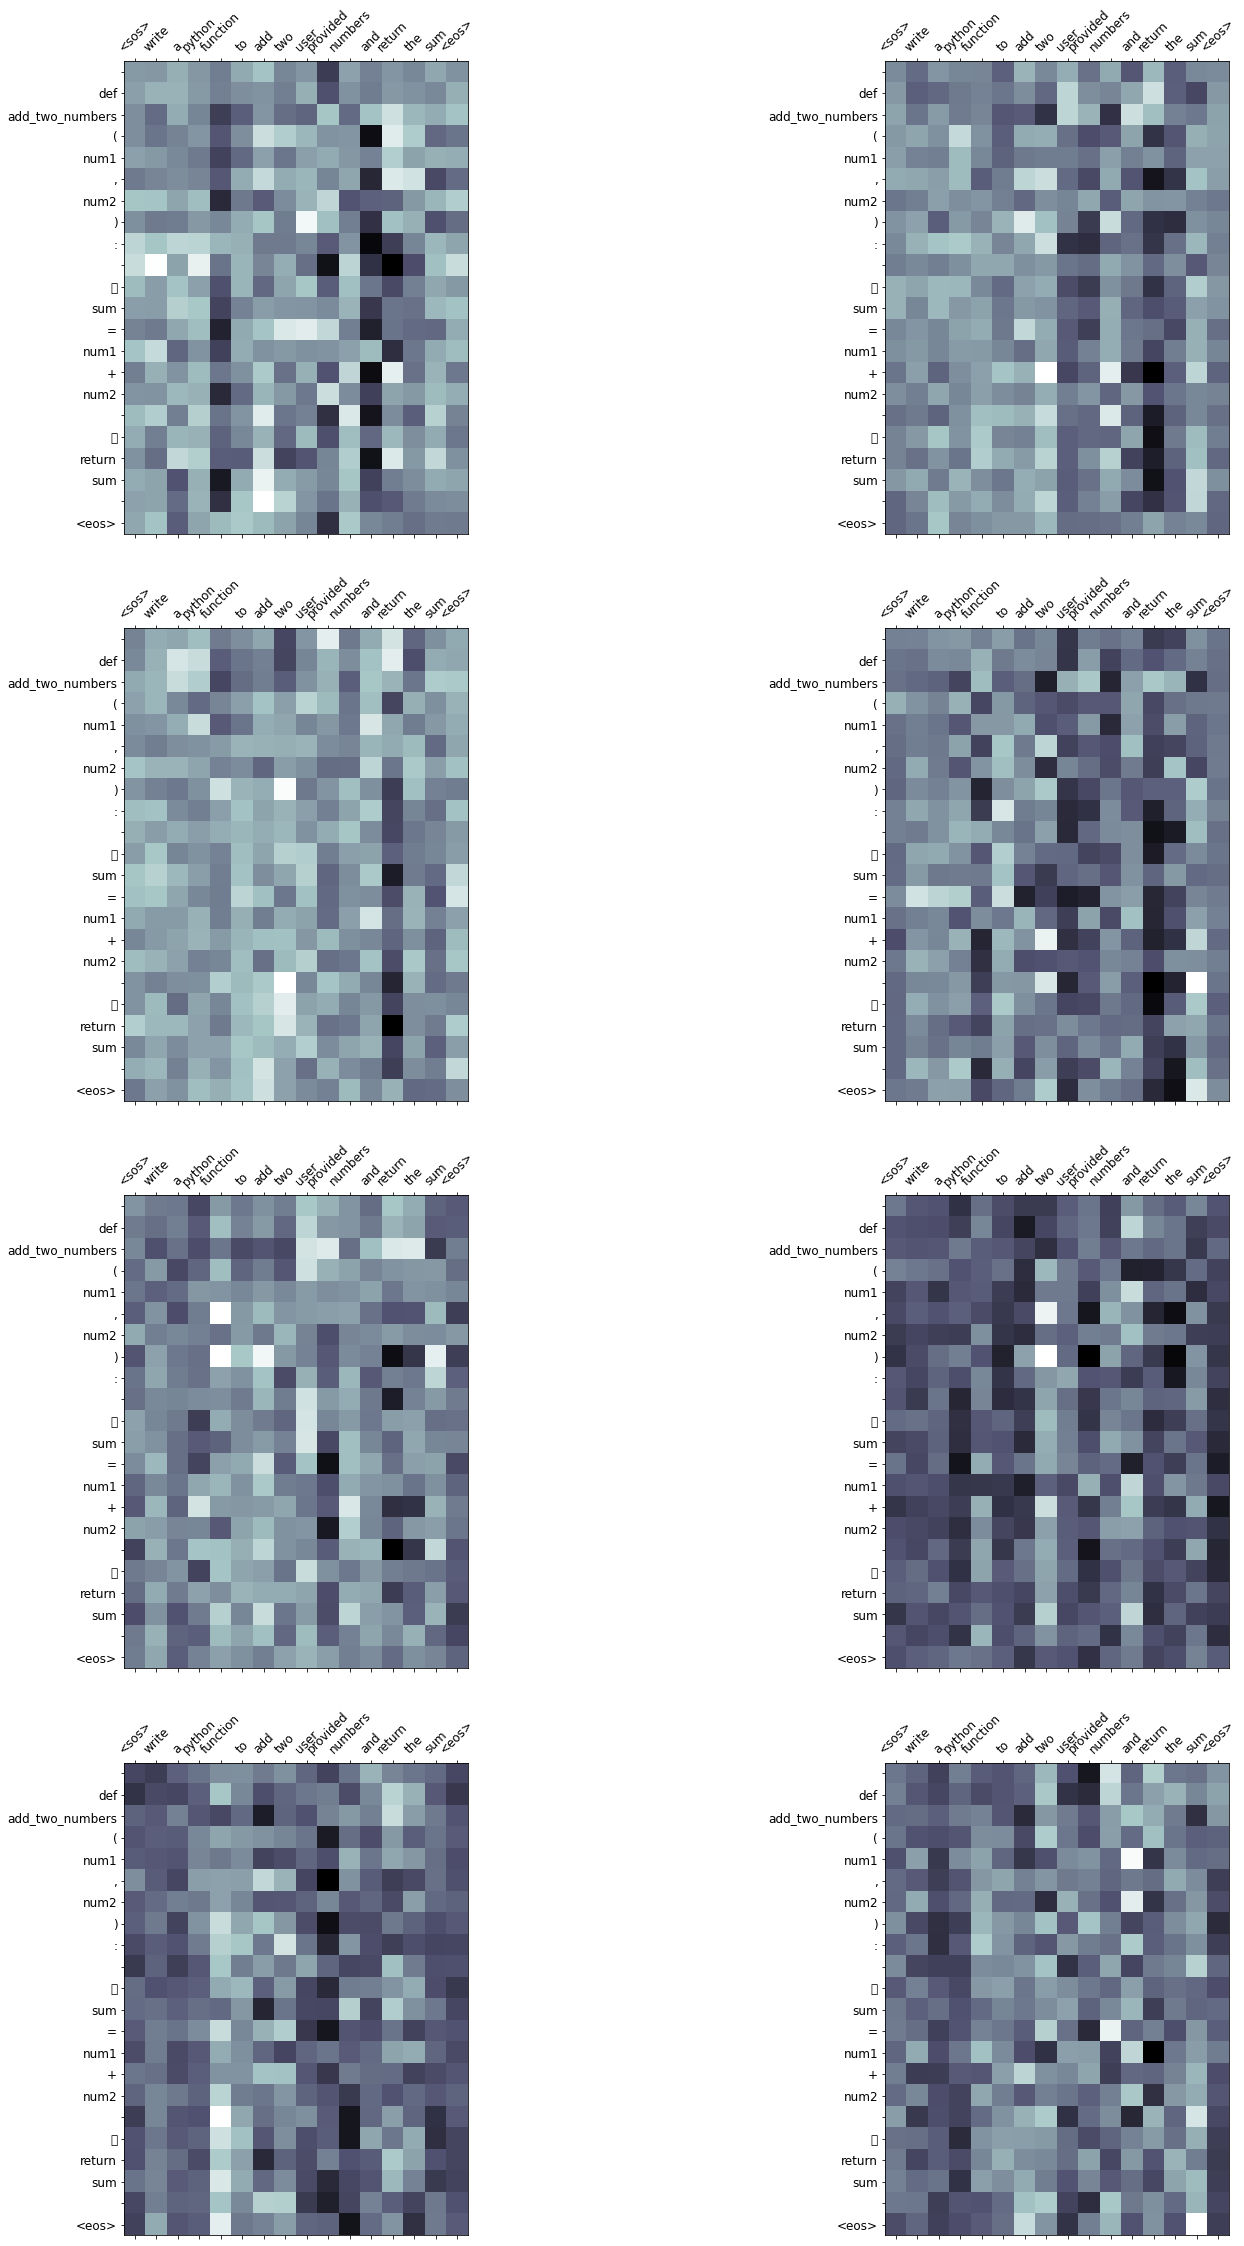

In [41]:
display_attention(src, translation, attention)

In [42]:
example_idx = 7

src = vars(test_data.examples[example_idx])['Description']
trg = vars(test_data.examples[example_idx])['Code']

print(f'src = {src}')
print(f'trg = {trg}')

print(" ".join(trg))

src = ['write', 'a', 'python', 'function', 'to', 'find', 'the', 'number', 'of', 'notes', '(', 'sample', 'of', 'notes', ':', '10', ',', '20', ',', '50', ',', '100', ',', '200', 'and', '500', ')', 'against', 'a', 'given', 'amount', '.']
trg = ['', 'def', 'no_notes', '(', 'a', ')', ':', '\n', '\t', 'Q', '=', '[', '500', ',', '200', ',', '100', ',', '50', ',', '20', ',', '10', ',', '5', ',', '2', ',', '1', ']', '\n', '\t', 'x', '=', '0', '\n', '\t', 'for', 'i', 'in', 'range', '(', '9', ')', ':', '\n', '\t\t', 'q', '=', 'Q', '[', 'i', ']', '\n', '\t\t', 'x', '+=', 'int', '(', 'a', '/', 'q', ')', '\n', '\t\t', 'a', '=', 'int', '(', 'a', '%', 'q', ')', '\n', '\t', 'if', 'a', '>', '0', ':', '\n', '\t\t', 'x', '=', '-', '1', '\n', '\t', 'return', 'x', '']
 def no_notes ( a ) : 
 	 Q = [ 500 , 200 , 100 , 50 , 20 , 10 , 5 , 2 , 1 ] 
 	 x = 0 
 	 for i in range ( 9 ) : 
 		 q = Q [ i ] 
 		 x += int ( a / q ) 
 		 a = int ( a % q ) 
 	 if a > 0 : 
 		 x = - 1 
 	 return x 


In [43]:
translation, attention = helper.predict_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

print(" ".join(translation))

predicted trg = ['', '\n', '', 'a', '=', 'int', '(', 'input', '(', '"Enter an integer:"', ')', ')', '\n', '', 'a', '=', 'int', '(', 'input', '(', 'a', ')', ')', '\n', '', 'b', '=', 'int', '(', 'a', ')', '\n', '', 'for', 'i', 'in', 'range', '(', '1', ',', 'n', ')', ':', '\n', '\t', 'a', '[', 'i', ']', '=', 'a', '/', '2', '\n', '\t', 'a', '=', 'a', '/', 'a', '\n', '\t', 'a', '=', 'a', '/', 'a', '\n', '\t', 'a', '=', 'a', '/', 'b', '\n', '\t', 'print', '(', 'a', ')', '', '<eos>']
 
  a = int ( input ( "Enter an integer:" ) ) 
  a = int ( input ( a ) ) 
  b = int ( a ) 
  for i in range ( 1 , n ) : 
 	 a [ i ] = a / 2 
 	 a = a / a 
 	 a = a / a 
 	 a = a / b 
 	 print ( a )  <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


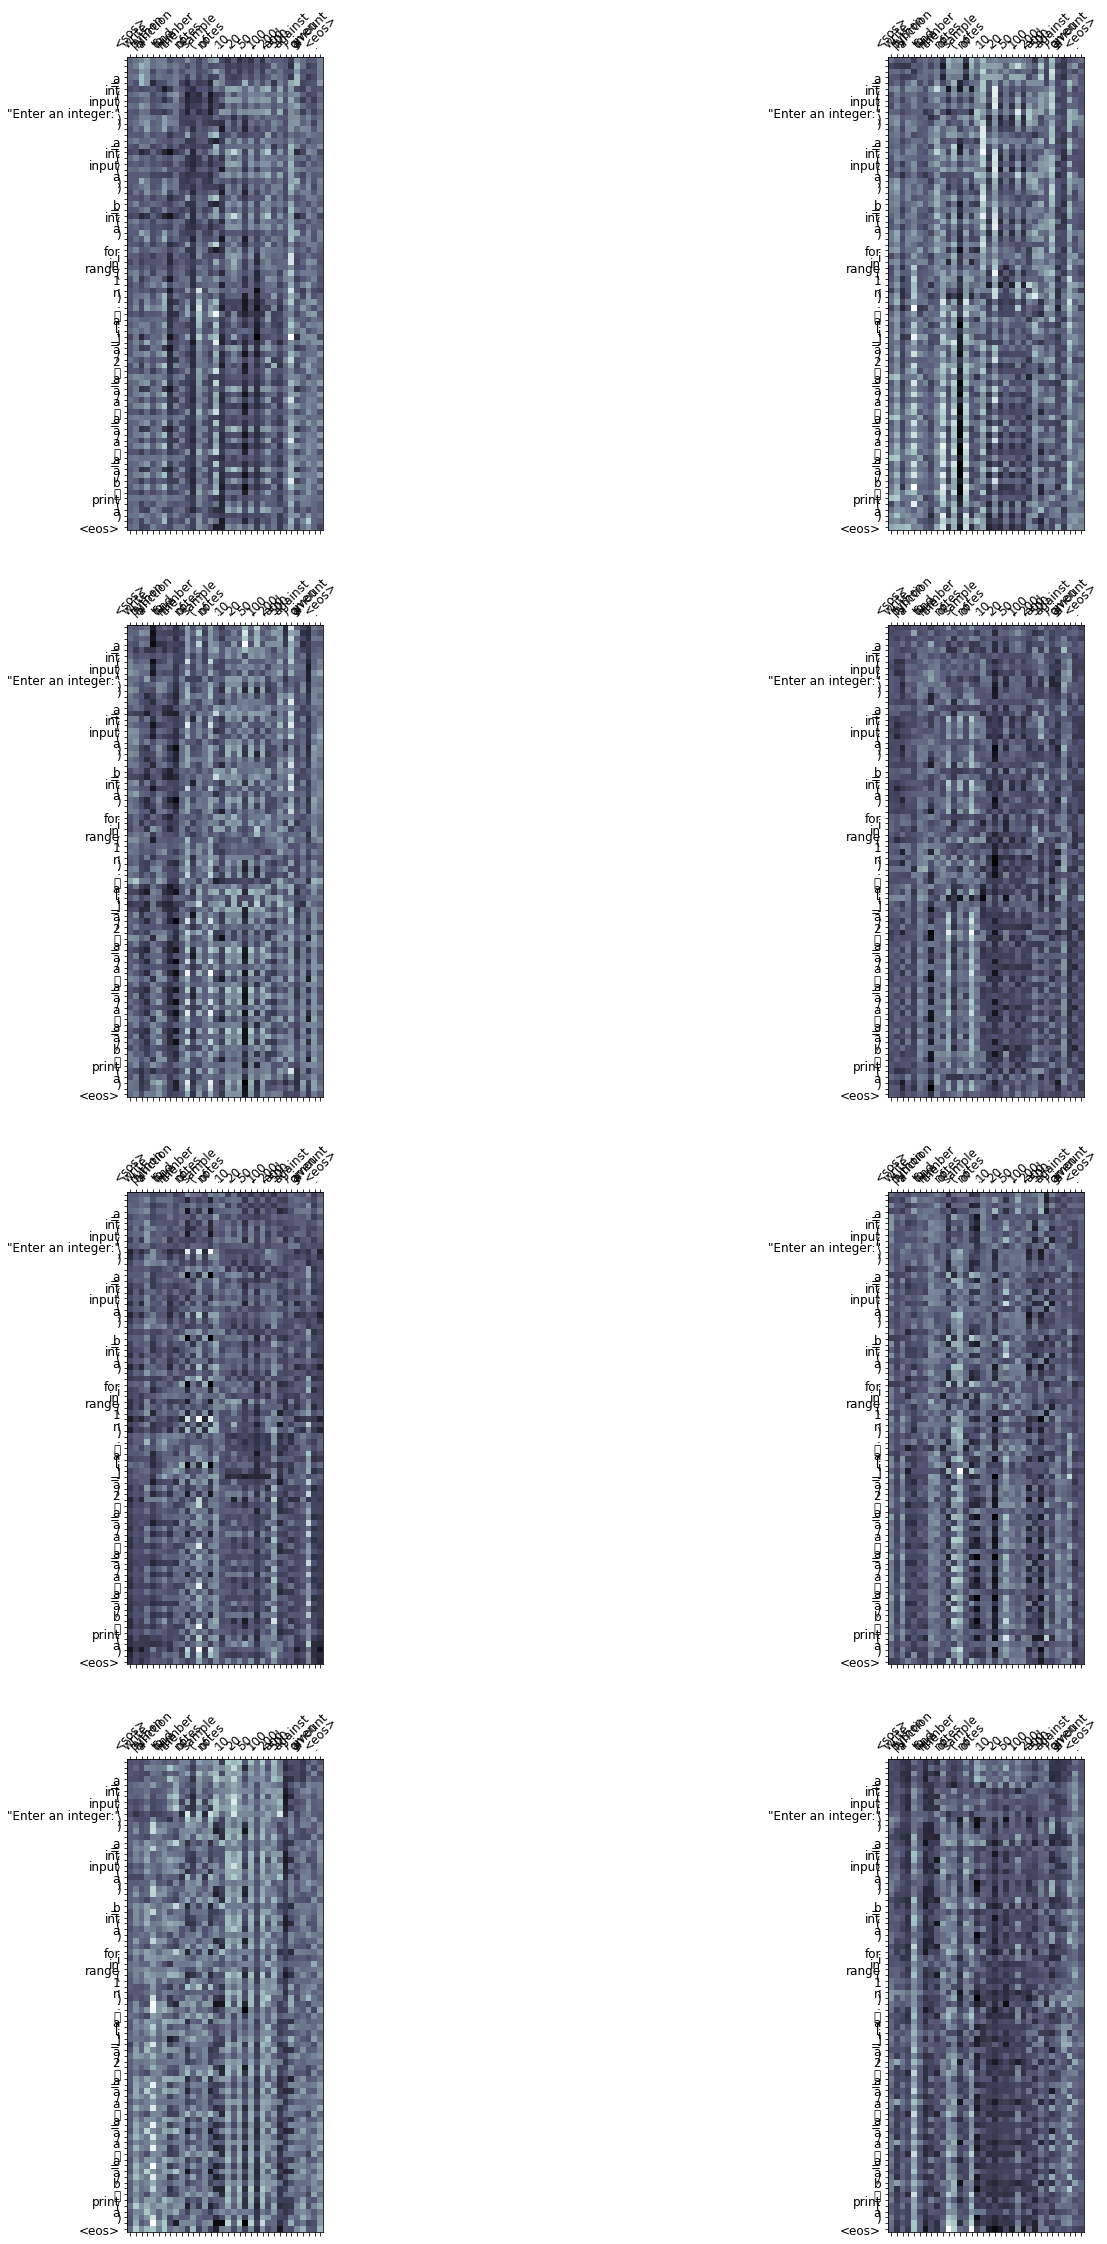

In [44]:
display_attention(src, translation, attention)